In [1]:
import PIL
from PIL import Image
from PIL import ExifTags

img = Image.open("sample.jpg")
depth = Image.open("sample-depth.jpg")

# focal length
exif = {ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS}
old_focal_mm = float(exif["FocalLength"])
# # newer PIL versions return focal length in mm but this version returns a tuple
# old_focal_mm = old_focal_mm[0] / old_focal_mm[1]

new_focal_mm_multiplier = 3.
if new_focal_mm_multiplier <= 1.:
    raise ValueError('new_focal_mm_multiplier cannot be <= 1')
new_focal_mm = float(new_focal_mm_multiplier * old_focal_mm)
print(f'Readjusting from {old_focal_mm:.2f}mm to {new_focal_mm:.2f}mm')

# resize
img = img.resize(depth.size)


# # resize
# max_length = 512 # needs to be multiples of 256 or 512 otherwise some convolutional dim mismatch
# depth_x, depth_y = depth.size
# new_rescale_factor = max_length / max(depth_x, depth_y) if max(depth_x, depth_y) > max_length else 1.
# print(f'Rescale by: {new_rescale_factor:.2f} to make 512 max length')
# new_x, new_y = int(depth_x * new_rescale_factor), int(depth_y * new_rescale_factor)
# img = img.resize(size=(new_x, new_y))
# depth = depth.resize(size=(new_x, new_y))

Readjusting from 5.10mm to 15.30mm


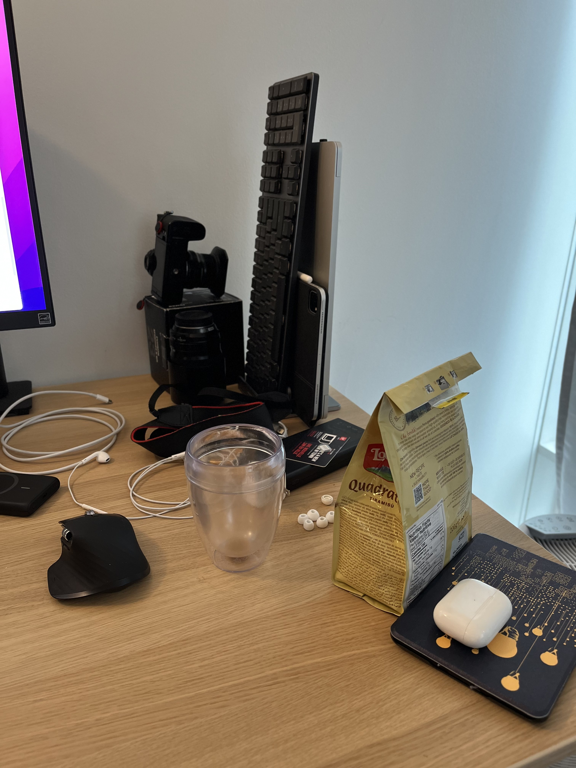

In [2]:
img

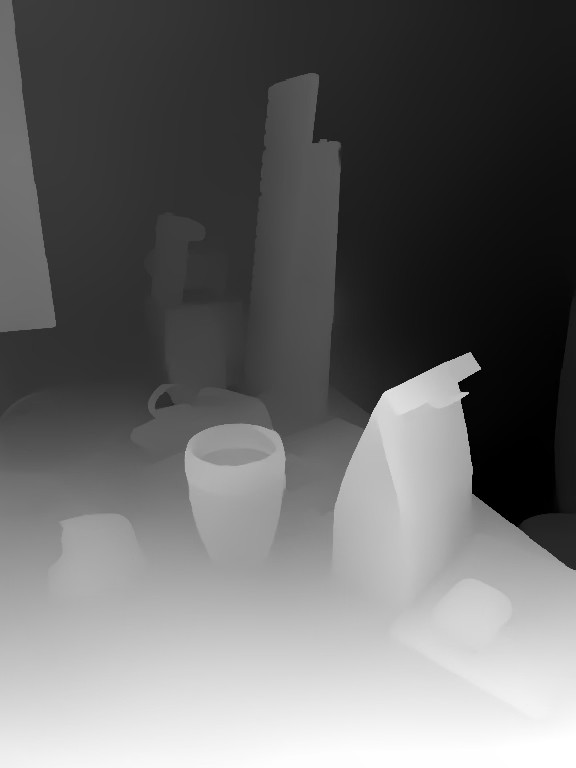

In [3]:
depth

In [4]:
import numpy as np

img_arr = np.asarray(img.convert("RGBA"))
depth_arr = np.asarray(depth)[:, :, 0] # any channel is the same since it's black and white
img_arr.shape, depth_arr.shape

((768, 576, 4), (768, 576))

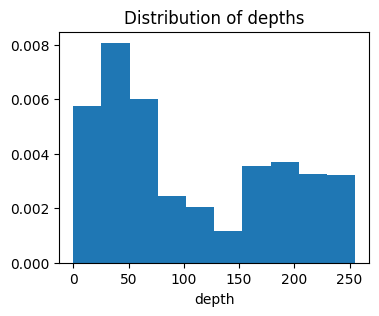

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.hist(depth_arr.reshape(-1), density=True)
plt.xlabel('depth')
plt.title('Distribution of depths')

# depth is in range(0, 256)
assert 0 == depth_arr.min() and depth_arr.max() == 255 

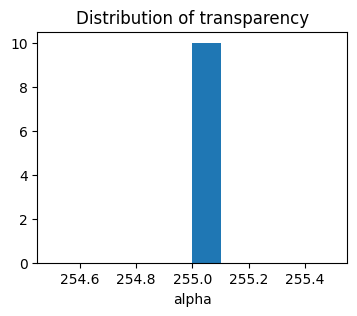

In [6]:
plt.figure(figsize=(4, 3))
plt.hist(img_arr[:, :, 3].reshape(-1), density=True)
plt.xlabel('alpha')
plt.title('Distribution of transparency')
assert 255 == img_arr[:, :, 3].min() == img_arr[:, :, 3].max()

In [7]:
# create depth for effect
# d > old focal length and d > new focal length
# decrease depth_min_multiplier to exaggerate close-up effect
depth_min_multiplier, depth_max_multiplier = 2., 10.
depth_min = depth_min_multiplier * max(new_focal_mm, old_focal_mm)
depth_max = depth_max_multiplier * max(new_focal_mm, old_focal_mm)
depth_min, depth_max

(30.599999999999998, 153.0)

In [8]:
depth_arr_transformed = depth_min + (depth_arr / 256) * (depth_max - depth_min)
depth_arr_transformed.min(), depth_arr_transformed.max()

(30.599999999999998, 152.521875)

In [9]:
def get_scaling(old_f_in_mm, new_f_in_mm, depth_in_mm) -> float:
    if depth_in_mm < min(new_f_in_mm, old_f_in_mm):
        raise ValueError('Depth cannot be smaller than new_f_in_mm or old_f_in_mm')
    res = (new_f_in_mm / (depth_in_mm - new_f_in_mm))
    res = res / (old_f_in_mm / (depth_in_mm - old_f_in_mm))
    return res


# focal length is proportional to image size
assert get_scaling(2, 3, 5) > 1
assert get_scaling(3, 2, 5) < 1
# for long distances, image size change is focal length change (i.e. zooming)
assert np.abs(get_scaling(3, 2, 1e9) - 2 / 3) < 1e-3


In [10]:
from tqdm import tqdm

size_x, size_y = img.size

# in RGBA format
init_img_arr = np.zeros(shape=img_arr.shape, dtype=np.uint8)
img_arr_d_dict = {}

def get_rescaled_and_center_crop(m, scaling_factor):
    m = m.copy()
    x, y = m.shape[1], m.shape[0]
    new_x, new_y = int(x * scaling_factor), int(y * scaling_factor)
    return np.asarray(
        Image
        .fromarray(m)
        .resize((new_x, new_y))
        # # use NEAREST to prevent smudging of edges
        # .resize((new_x, new_y), resample=PIL.Image.NEAREST)
        .crop(box=(
            (new_x - x) // 2,
            (new_y - y) // 2,
            x,
            y
        ))
        .resize((x, y))
    )


# start writing the furthest transformed pixels
for d in sorted(np.unique(depth_arr_transformed), reverse=True):

    # this modified scaling factor preserves unity at infinity
    scaling = get_scaling(old_f_in_mm=old_focal_mm, new_f_in_mm=new_focal_mm, depth_in_mm=d)
    scaling = scaling / (new_focal_mm / old_focal_mm)
    new_size_x, new_size_y = int(size_x * scaling), int(size_y * scaling)

    # img_arr_d = np.zeros(shape=img_arr.shape, dtype=np.uint8)
    # img_arr_d[depth_arr_transformed == d] = img_arr[depth_arr_transformed == d]
    # img_arr_d = get_rescaled_and_center_crop(m=img_arr_d, scaling_factor=scaling)
    # is_not_masked = img_arr_d[:, :, 3] > 0

    # init_img_arr[is_not_masked] = img_arr_d[is_not_masked]

    mask_arr_d = np.zeros(shape=img_arr.shape, dtype=np.uint8)
    mask_arr_d[depth_arr_transformed == d] = 255

    img_arr_d = get_rescaled_and_center_crop(m=img_arr, scaling_factor=scaling)
    mask_arr_d = get_rescaled_and_center_crop(m=mask_arr_d, scaling_factor=scaling)
    # print(img_arr_d.shape, mask_arr_d.shape)

    is_not_masked = mask_arr_d[:, :, 3] > 0

    init_img_arr[is_not_masked] = img_arr_d[is_not_masked]

mask_image_arr = np.zeros(shape=img_arr.shape, dtype=np.uint8)
mask_image_arr[init_img_arr[:, :, 3] == 0] = 255

In [11]:
num_transparent_pixels = len(list(zip(*np.where(init_img_arr[:, :, 3] == 0))))

f'Need to fill {num_transparent_pixels} ({100*num_transparent_pixels/depth_arr.size:.2f}%) pixels'

'Need to fill 18751 (4.24%) pixels'

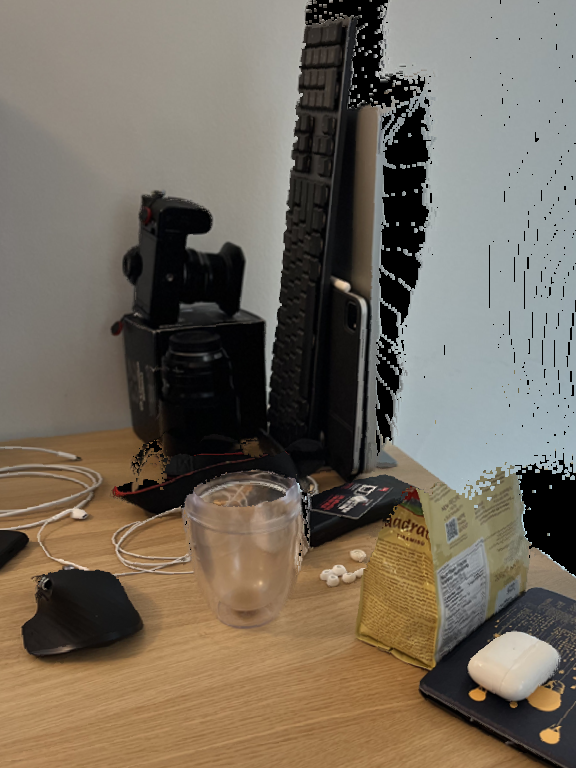

In [12]:
init_image = Image.fromarray(init_img_arr).convert("RGB")
init_image

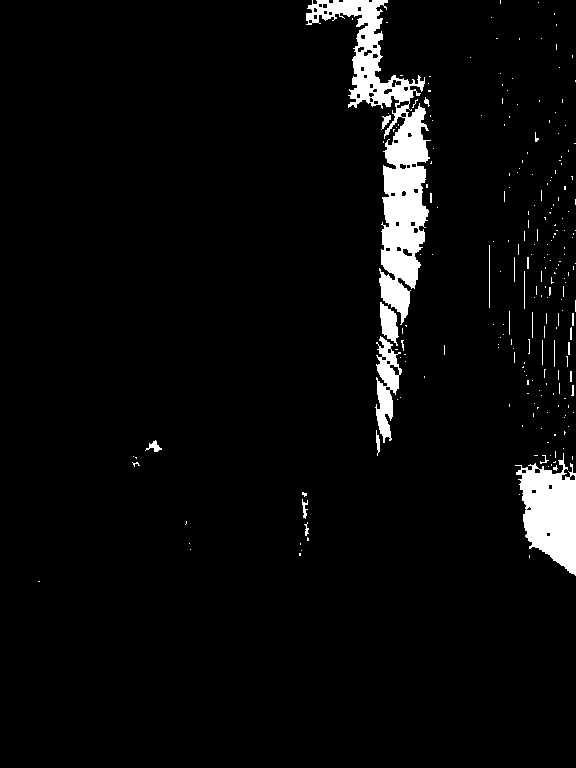

In [13]:
mask_image = Image.fromarray(mask_image_arr).convert("RGB")
mask_image

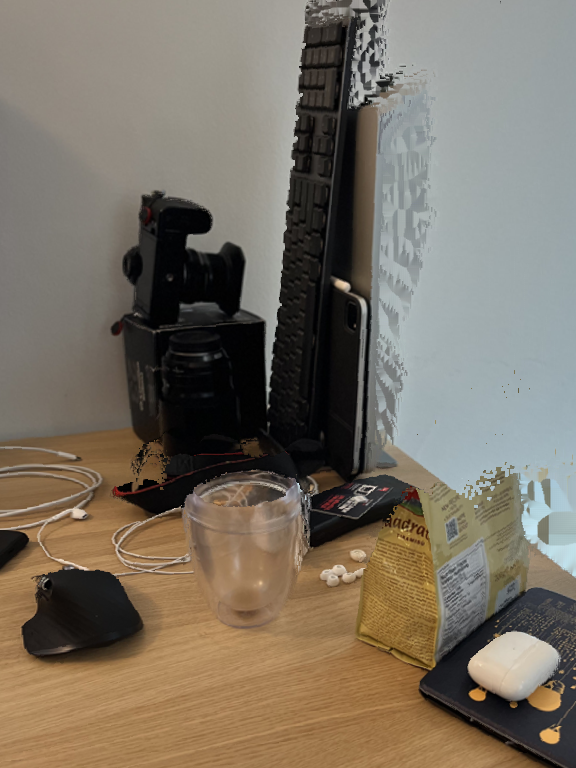

In [14]:
import cv2 as cv
# from google.colab.patches import cv2_imshow

def pil_img_to_cv(pil_image):
    open_cv_image = np.array(pil_image) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    return open_cv_image

dst = cv.inpaint(
    pil_img_to_cv(init_image),
    pil_img_to_cv(mask_image)[:, :, 0],
    0, 
    cv.INPAINT_TELEA
    # cv.INPAINT_NS
)

dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
Image.fromarray(dst)